In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv


In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import difflib
import warnings
warnings.simplefilter("ignore")

In [4]:
# Many placeholder values use '\N', will need to replace this in data cleaning
races = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/races.csv', na_values='\\N')
results = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv', na_values='\\N')
drivers = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv', na_values='\\N')
constructors = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv', na_values='\\N')


In [5]:
# Basic information about the datasets
print("Races dataset shape:", races.shape)
print("\nRaces dataset columns:", races.columns.tolist())


Races dataset shape: (1125, 18)

Races dataset columns: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']


In [6]:
print("\nResults dataset shape:", results.shape)
print("\nResults dataset columns:", results.columns.tolist())


Results dataset shape: (26759, 18)

Results dataset columns: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']


In [7]:
print("Races dataset shape:", drivers.shape)
print("\nRaces dataset columns:", drivers.columns.tolist())


Races dataset shape: (861, 9)

Races dataset columns: ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']


In [8]:
print("Constructors dataset shape:", constructors.shape)
print("\nConstructors dataset columns:", constructors.columns.tolist())

Constructors dataset shape: (212, 5)

Constructors dataset columns: ['constructorId', 'constructorRef', 'name', 'nationality', 'url']


In [9]:
# Merge relevant tables
race_results = pd.merge(races, results, on='raceId')
race_results = pd.merge(race_results, drivers, on='driverId')
race_results = pd.merge(race_results, constructors, on='constructorId')

# Show the merged dataset
print("\nMerged dataset shape:", race_results.shape)
print("\nMerged dataset columns:", race_results.columns.tolist())



Merged dataset shape: (26759, 47)

Merged dataset columns: ['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time_y', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef', 'number_y', 'code', 'forename', 'surname', 'dob', 'nationality_x', 'url_y', 'constructorRef', 'name_y', 'nationality_y', 'url']


In [10]:
# Create target variable using position order. This will be a binary that will say if someone is on the podium or not
race_results['podium_finish'] = (race_results['positionOrder'] <= 3).astype(int)

# Create full name for drivers
race_results['driver_name'] = race_results['forename'] + ' ' + race_results['surname']

In [11]:
# These are the only columns we need, and there's more unwanted columns so we won't drop, just update the df
relevant_columns = [
                    'raceId', 'year', 'round', 'circuitId', 'grid', 'position',
                    'points', 'laps', 'fastestLapSpeed', 'driverId', 'driver_name',
                    'constructorId', 'podium_finish'
                   ]

race_results = race_results[relevant_columns]
race_results.head()

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23,1
1,1,2009,1,1,2,2.0,8.0,58,214.344,22,Rubens Barrichello,23,1
2,1,2009,1,1,20,3.0,6.0,58,214.706,15,Jarno Trulli,7,1
3,1,2009,1,1,19,4.0,5.0,58,215.920,10,Timo Glock,7,0
4,1,2009,1,1,10,5.0,4.0,58,215.199,4,Fernando Alonso,4,0


In [12]:
race_results.tail()

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
26754,1144,2024,24,24,14,16.0,0.0,57,222.002,825,Kevin Magnussen,210,0
26755,1144,2024,24,24,12,17.0,0.0,55,214.212,859,Liam Lawson,215,0
26756,1144,2024,24,24,9,NaN,0.0,30,212.462,822,Valtteri Bottas,15,0
26757,1144,2024,24,24,20,NaN,0.0,26,212.631,861,Franco Colapinto,3,0
26758,1144,2024,24,24,10,NaN,0.0,0,NaN,815,Sergio Pérez,9,0


In [13]:
# Handle missing values. The dataset originally had \N as a placeholder, so we need to keep that in mind
print(race_results.isnull().sum())

raceId                 0
year                   0
round                  0
circuitId              0
grid                   0
position           10953
points                 0
laps                   0
fastestLapSpeed    18507
driverId               0
driver_name            0
constructorId          0
podium_finish          0
dtype: int64


In [14]:
# For numerical columns, fill NAs with 0
numerical_columns = race_results.select_dtypes(include=[np.number]).columns
race_results[numerical_columns] = race_results[numerical_columns].fillna(0)

# For categorical columns, fill NAs with Unknown
categorical_columns = race_results.select_dtypes(include=['object']).columns
race_results[categorical_columns] = race_results[categorical_columns].fillna('Unknown')


In [15]:
# Check missing values after handling
print("\nMissing values after handling:")
print(race_results.isnull().sum())


Missing values after handling:
raceId             0
year               0
round              0
circuitId          0
grid               0
position           0
points             0
laps               0
fastestLapSpeed    0
driverId           0
driver_name        0
constructorId      0
podium_finish      0
dtype: int64


In [16]:
# Remove duplicates if any
duplicates_count = race_results.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")
race_results = race_results.drop_duplicates()



Number of duplicate rows: 0


In [17]:
# Display basic information about the cleaned dataset
print("\nCleaned dataset info:")
print(race_results.info())


Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           26759 non-null  int64  
 1   year             26759 non-null  int64  
 2   round            26759 non-null  int64  
 3   circuitId        26759 non-null  int64  
 4   grid             26759 non-null  int64  
 5   position         26759 non-null  float64
 6   points           26759 non-null  float64
 7   laps             26759 non-null  int64  
 8   fastestLapSpeed  26759 non-null  float64
 9   driverId         26759 non-null  int64  
 10  driver_name      26759 non-null  object 
 11  constructorId    26759 non-null  int64  
 12  podium_finish    26759 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 2.7+ MB
None


In [18]:
race_results.head(10)

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23,1
1,1,2009,1,1,2,2.0,8.0,58,214.344,22,Rubens Barrichello,23,1
2,1,2009,1,1,20,3.0,6.0,58,214.706,15,Jarno Trulli,7,1
3,1,2009,1,1,19,4.0,5.0,58,215.920,10,Timo Glock,7,0
4,1,2009,1,1,10,5.0,4.0,58,215.199,4,Fernando Alonso,4,0
5,1,2009,1,1,5,6.0,3.0,58,217.668,3,Nico Rosberg,3,0
6,1,2009,1,1,13,7.0,2.0,58,213.950,67,Sébastien Buemi,5,0
7,1,2009,1,1,17,8.0,1.0,58,212.537,7,Sébastien Bourdais,5,0
8,1,2009,1,1,16,9.0,0.0,58,214.640,16,Adrian Sutil,10,0
9,1,2009,1,1,9,10.0,0.0,58,216.245,2,Nick Heidfeld,2,0


In [19]:
race_results.tail(10)


,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
26749,1144,2024,24,24,18,11.0,0.0,57,212.567,848,Alexander Albon,3,0
26750,1144,2024,24,24,11,12.0,0.0,57,213.134,852,Yuki Tsunoda,215,0
26751,1144,2024,24,24,15,13.0,0.0,57,216.085,855,Guanyu Zhou,15,0
26752,1144,2024,24,24,13,14.0,0.0,57,214.568,840,Lance Stroll,117,0
26753,1144,2024,24,24,17,15.0,0.0,57,213.323,862,Jack Doohan,214,0
26754,1144,2024,24,24,14,16.0,0.0,57,222.002,825,Kevin Magnussen,210,0
26755,1144,2024,24,24,12,17.0,0.0,55,214.212,859,Liam Lawson,215,0
26756,1144,2024,24,24,9,0.0,0.0,30,212.462,822,Valtteri Bottas,15,0
26757,1144,2024,24,24,20,0.0,0.0,26,212.631,861,Franco Colapinto,3,0
26758,1144,2024,24,24,10,0.0,0.0,0,0.000,815,Sergio Pérez,9,0


In [20]:
# Display final shape and columns of the cleaned df
print("\nFinal shape of the cleaned dataset:", race_results.shape)
print("\nColumns in the cleaned dataset:")
print(race_results.columns.tolist())


Final shape of the cleaned dataset: (26759, 13)

Columns in the cleaned dataset:
['raceId', 'year', 'round', 'circuitId', 'grid', 'position', 'points', 'laps', 'fastestLapSpeed', 'driverId', 'driver_name', 'constructorId', 'podium_finish']


In [21]:
# Descriptive statistics
print(race_results.describe())

             raceId          year         round     circuitId          grid  \
count  26759.000000  26759.000000  26759.000000  26759.000000  26759.000000   
mean     551.687283   1991.394372      8.511192     23.820808     11.134796   
std      313.265036     19.952885      5.070231     19.112002      7.202860   
min        1.000000   1950.000000      1.000000      1.000000      0.000000   
25%      300.000000   1977.000000      4.000000      9.000000      5.000000   
50%      531.000000   1991.000000      8.000000     18.000000     11.000000   
75%      811.000000   2009.000000     12.000000     34.000000     17.000000   
max     1144.000000   2024.000000     24.000000     80.000000     34.000000   

           position        points          laps  fastestLapSpeed  \
count  26759.000000  26759.000000  26759.000000     26759.000000   
mean       4.737546      1.987632     46.301768        62.945848   
std        5.421710      4.351209     29.496557        95.012330   
min        0.000

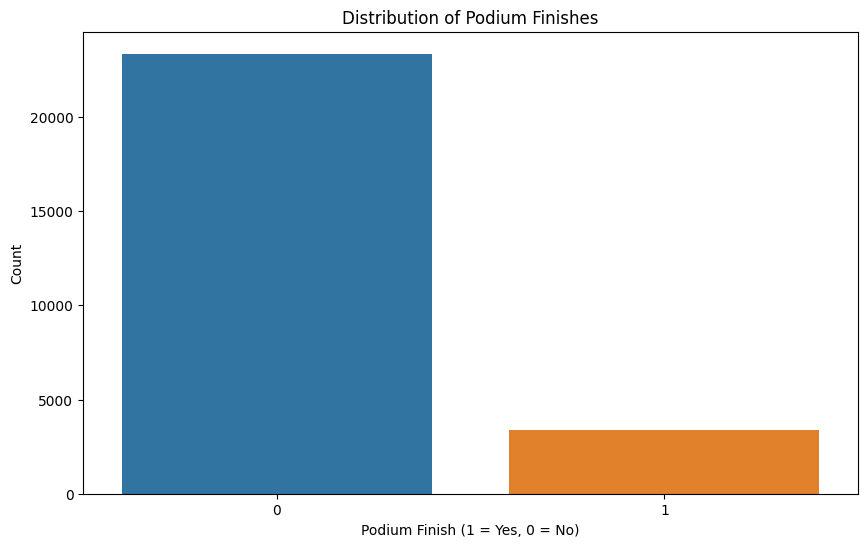

In [22]:
# Distribution of podium finishes
plt.figure(figsize=(10, 6))
sns.countplot(x='podium_finish', data=race_results)
plt.title('Distribution of Podium Finishes')
plt.xlabel('Podium Finish (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

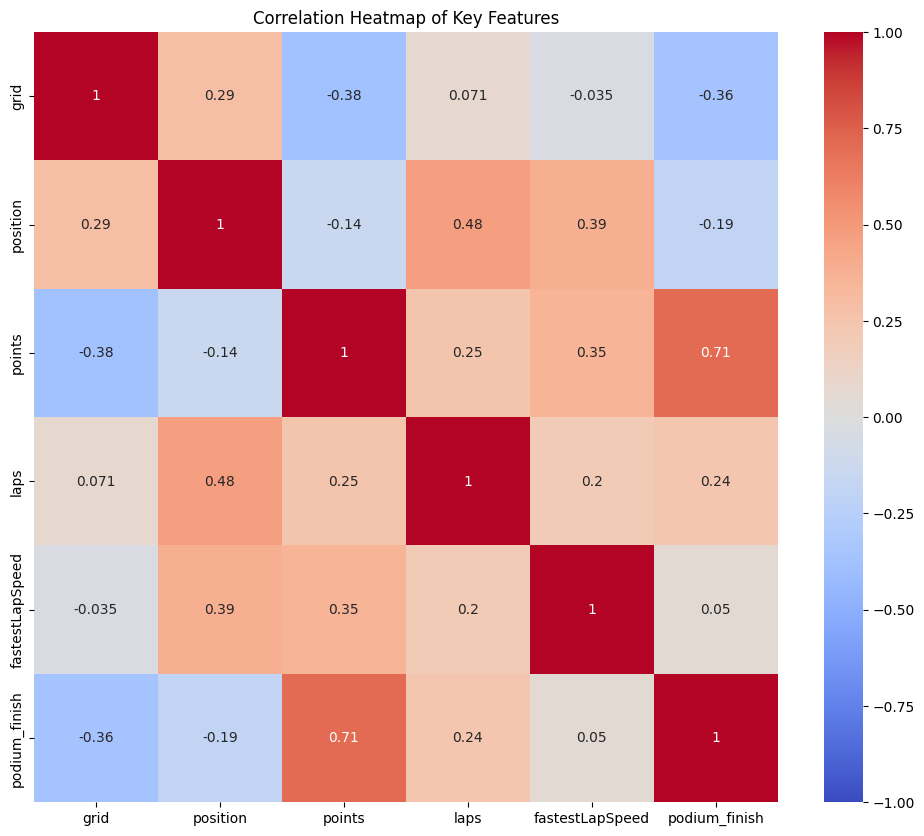

In [23]:
race_results_cleaned = race_results.copy()

heatmap_columns = ['grid', 'position', 'points',
                   'laps', 'fastestLapSpeed', 'podium_finish']
# Replace '\\N' with NaN and convert columns to numeric
for column in heatmap_columns:
    # Replace '\\N' with NaN
    race_results_cleaned[column] = race_results_cleaned[column].replace('\\N', np.nan)
    # Convert the column to numeric, errors='coerce' will handle any remaining non-numeric values
    race_results_cleaned[column] = pd.to_numeric(race_results_cleaned[column], errors='coerce')


# Create correlation matrix
corr = race_results_cleaned[heatmap_columns].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Features')
plt.show()

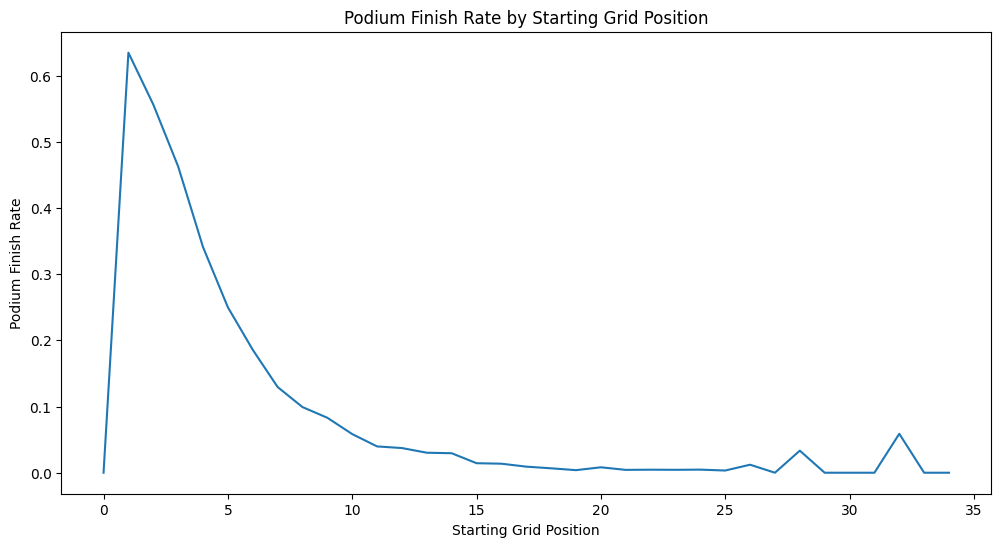

In [24]:
# Podium finish rate by starting position
podium_rate = race_results.groupby('grid')['podium_finish'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=podium_rate.index, y=podium_rate.values)
plt.title('Podium Finish Rate by Starting Grid Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Podium Finish Rate')
plt.show()

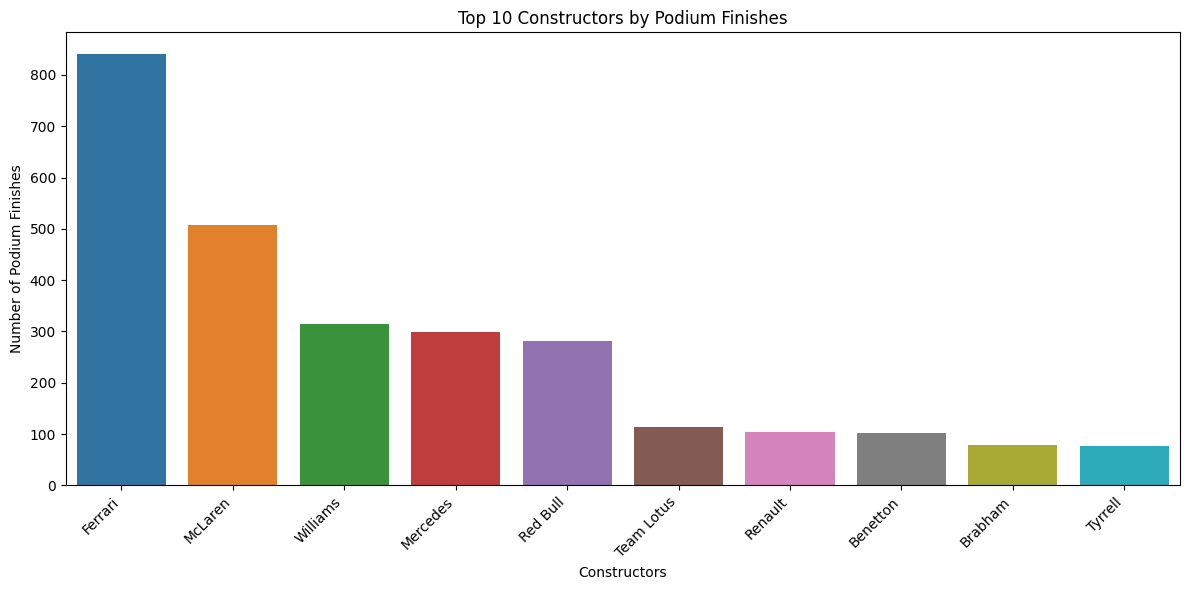

In [25]:
# top constructors
top_constructors = race_results.groupby('constructorId')['podium_finish'].sum().sort_values(ascending=False).head(10)
top_constructors = top_constructors.reset_index()
top_constructors = pd.merge(top_constructors, constructors[['constructorId', 'name']], on='constructorId')

# Bar plot for constructors and their podium finishes
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='podium_finish', data=top_constructors)
plt.title('Top 10 Constructors by Podium Finishes')
plt.xlabel('Constructors')
plt.ylabel('Number of Podium Finishes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


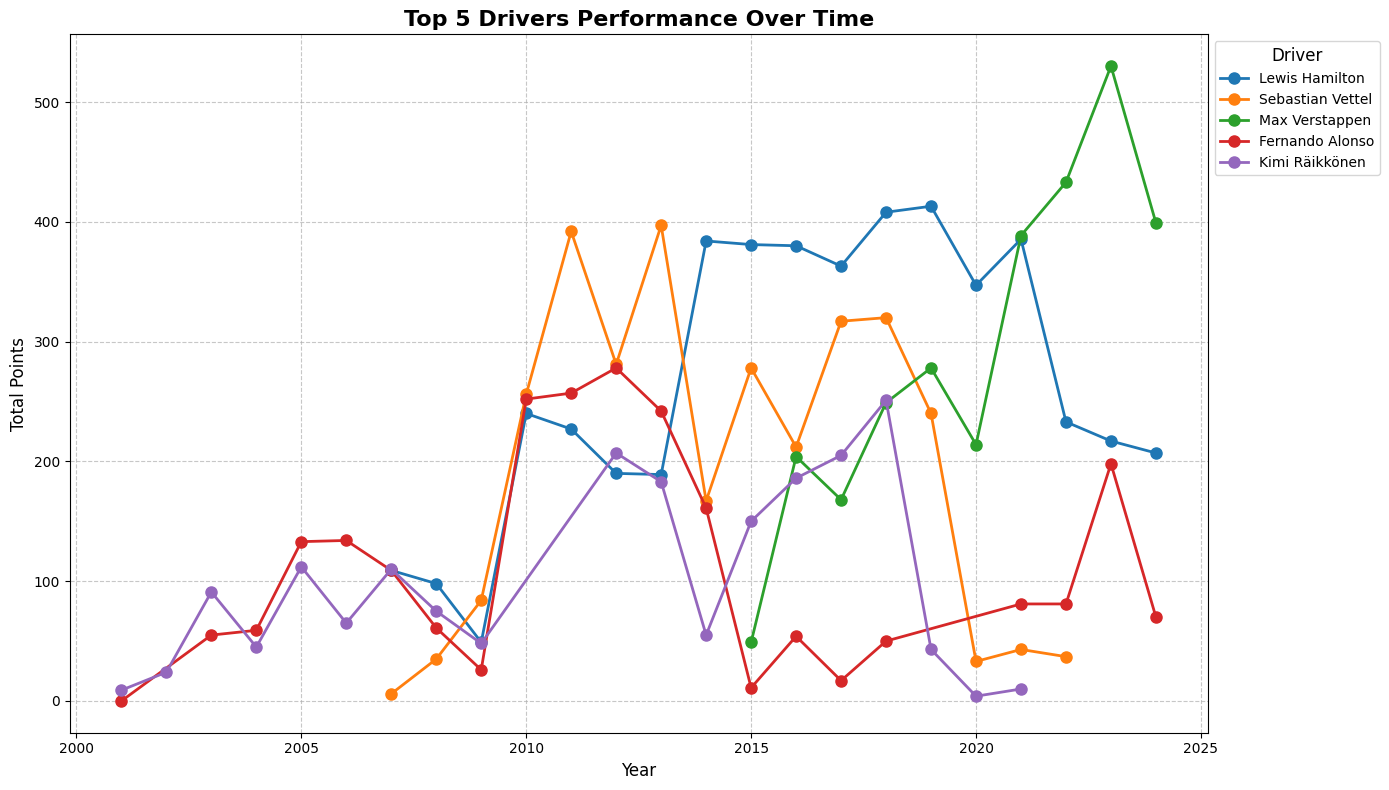

In [26]:
# Get top 5 drivers by total points
top_drivers = race_results.groupby('driver_name')['points'].sum().nlargest(5).index

# Filter data for top drivers
top_drivers_data = race_results[race_results['driver_name'].isin(top_drivers)]

# Create line plot
plt.figure(figsize=(14, 8))
for driver in top_drivers:
    driver_data = top_drivers_data[top_drivers_data['driver_name'] == driver]
    yearly_points = driver_data.groupby('year')['points'].sum()
    plt.plot(yearly_points.index, yearly_points.values, marker='o', linewidth=2, markersize=8, label=driver)

plt.title('Top 5 Drivers Performance Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Points', fontsize=12)
plt.legend(title='Driver', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

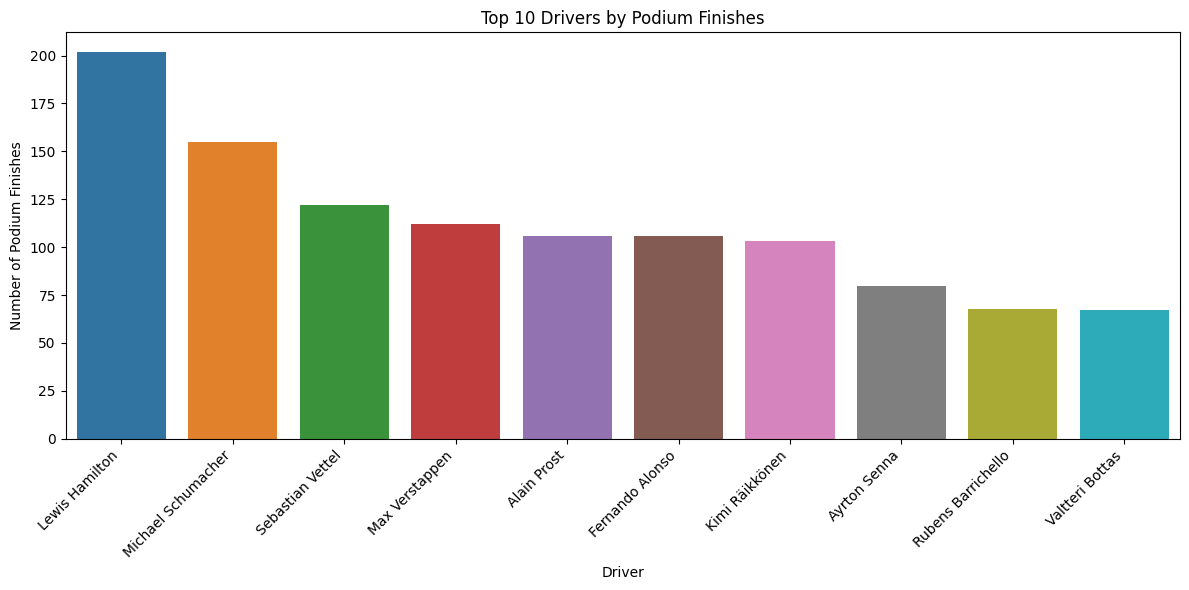

In [27]:
# Top 10 drivers by podium finishes
top_drivers = race_results.groupby('driver_name')['podium_finish'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_drivers.index, y=top_drivers.values)
plt.title('Top 10 Drivers by Podium Finishes')
plt.xlabel('Driver')
plt.ylabel('Number of Podium Finishes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

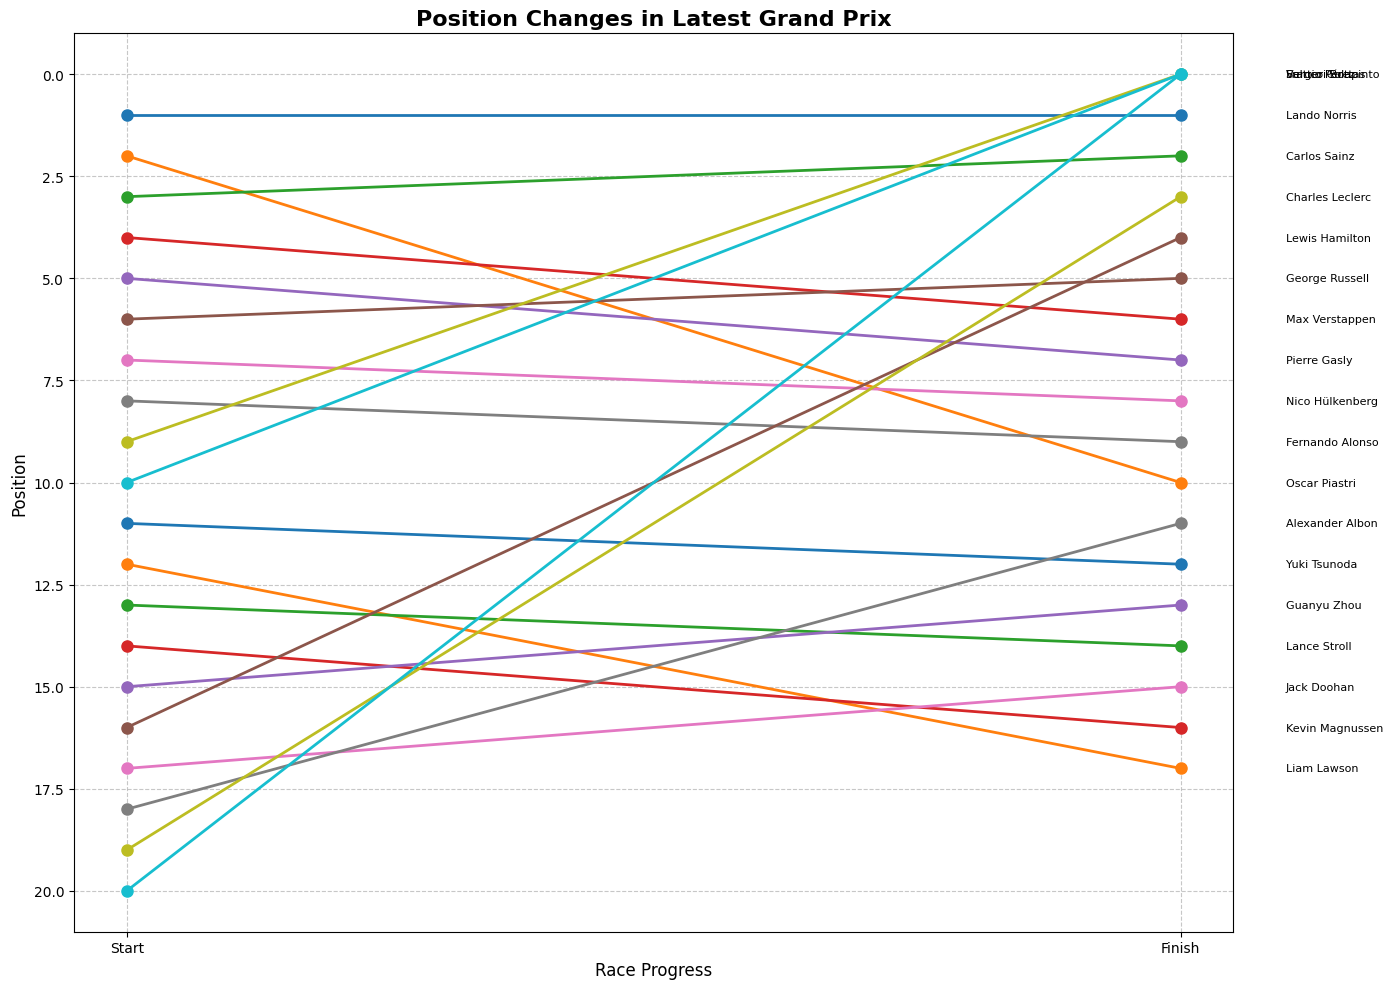

In [28]:
# Sample race grid position and ending position
latest_race = race_results['raceId'].max()
race_data = race_results[race_results['raceId'] == latest_race].sort_values('grid')

plt.figure(figsize=(14, 10))
for _, driver in race_data.iterrows():
    plt.plot([1, 2], [driver['grid'], driver['position']], '-o', linewidth=2, markersize=8)
    plt.text(2.1, driver['position'], driver['driver_name'], fontsize=8, verticalalignment='center')

plt.title(f'Position Changes in Latest Grand Prix', fontsize=16, fontweight='bold')
plt.xlabel('Race Progress', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis so that 1st position is at the top
plt.xticks([1, 2], ['Start', 'Finish'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# Select features and target
features = ['grid', 'round','fastestLapSpeed']
X = race_results_cleaned[features]
y = race_results_cleaned['podium_finish']

In [30]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [31]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [32]:
# Display information about the preprocessed data
print("Features used:", features)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Features used: ['grid', 'round', 'fastestLapSpeed']
Shape of X_train: (21407, 3)
Shape of X_test: (5352, 3)
Shape of X_train_scaled: (21407, 3)
Shape of X_test_scaled: (5352, 3)


In [33]:
# Display the first few rows of the scaled training data
print("\nFirst few rows of scaled training data:")
print(X_train_scaled.head())


First few rows of scaled training data:
       grid     round  fastestLapSpeed
0 -0.437800 -1.087089        -0.663529
1 -1.550467  0.095968        -0.663529
2 -0.437800  0.687496        -0.663529
3  0.257616 -0.495561         1.438149
4  1.509367  1.476200        -0.663529


In [34]:
# Check for any remaining NaN or infinite values
print("\nColumns with NaN values in X_train_scaled:")
print(X_train_scaled.isna().sum()[X_train_scaled.isna().sum() > 0])
print("\nColumns with infinite values in X_train_scaled:")
print(np.isinf(X_train_scaled).sum()[np.isinf(X_train_scaled).sum() > 0])


Columns with NaN values in X_train_scaled:
Series([], dtype: int64)

Columns with infinite values in X_train_scaled:
Series([], dtype: int64)


In [38]:
### Random Forest

rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print("\nBest Random Forest parameters:", grid_search_rf.best_params_)
rf_best = grid_search_rf.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)


Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


In [39]:
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred)*100, "%")
print(classification_report(y_test, rf_pred))



Random Forest Results:
Accuracy: 88.17264573991032 %
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4657
           1       0.57      0.36      0.44       695

    accuracy                           0.88      5352
   macro avg       0.74      0.66      0.69      5352
weighted avg       0.87      0.88      0.87      5352



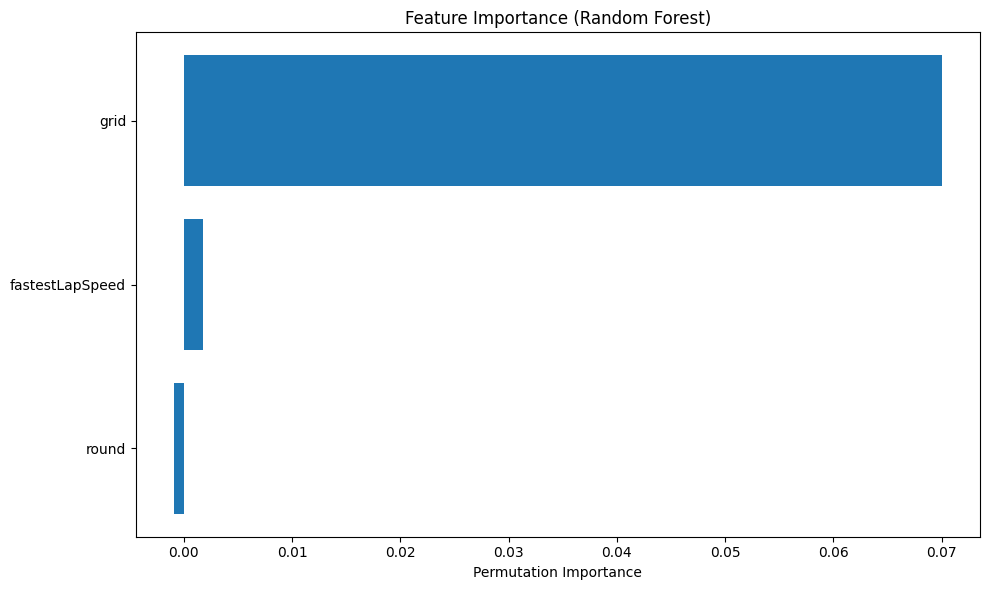

In [45]:
# Feature importance
plt.figure(figsize=(10, 6))
feature_importance = permutation_importance(rf_best, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = feature_importance.importances_mean.argsort()
plt.barh(range(X_test_scaled.shape[1]), feature_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test_scaled.shape[1]), X_test_scaled.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data
races = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/races.csv', na_values='\\N')
results = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv', na_values='\\N')
drivers = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv', na_values='\\N')
constructors = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv', na_values='\\N')

# Merge and prepare data
df = results.merge(races[['raceId', 'year', 'round', 'circuitId', 'name']], on='raceId')
df = df.merge(drivers[['driverId', 'driverRef', 'forename', 'surname']], on='driverId')
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', suffixes=('', '_constructor'))
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['grid'] = pd.to_numeric(df['grid'], errors='coerce')
df = df.sort_values(['driverId', 'year', 'round'])

# Rolling averages
df['driver_avg_position'] = df.groupby('driverId')['position'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df['driver_avg_grid'] = df.groupby('driverId')['grid'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df['constructor_avg_position'] = df.groupby('constructorId')['position'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df['top_3'] = (df['position'] <= 3).astype(int)

# Features and target
features = ['grid', 'driver_avg_position', 'driver_avg_grid', 'constructor_avg_position']
X = df[features].fillna(df[features].mean())
y = df['top_3']

from sklearn.metrics import accuracy_score, roc_auc_score

# Split into train+val and test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and val (60/20)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# Final: 60% train, 20% val, 20% test

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
val_preds = model.predict(X_val)
val_probs = model.predict_proba(X_val)[:, 1]
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation ROC AUC:", roc_auc_score(y_val, val_probs))

# Optional: Evaluate on test set
test_preds = model.predict(X_test)
test_probs = model.predict_proba(X_test)[:, 1]
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test ROC AUC:", roc_auc_score(y_test, test_probs))


# --- Predict for Miami 2025 ---

# Find the latest Miami race
miami_race = races[races['name'].str.contains('Miami', case=False)].sort_values('year').iloc[-1]
miami_raceId = miami_race['raceId']

# Get all drivers who participated in the latest Miami race
miami_results = df[df['raceId'] == miami_raceId]

# For each driver, get their last 5 races (simulate for 2025)
predictions = []
for idx, row in miami_results.iterrows():
    driver_id = row['driverId']
    constructor_id = row['constructorId']
    # Get last 5 races for this driver
    last5 = df[(df['driverId'] == driver_id) & (df['raceId'] <= miami_raceId)].sort_values('raceId').tail(5)
    # Get last 5 races for this constructor
    last5_constructor = df[(df['constructorId'] == constructor_id) & (df['raceId'] <= miami_raceId)].sort_values('raceId').tail(5)
    # Prepare features
    grid = row['grid']  # Use last Miami grid as proxy
    driver_avg_position = last5['position'].mean()
    driver_avg_grid = last5['grid'].mean()
    constructor_avg_position = last5_constructor['position'].mean()
    features_row = np.array([[grid, driver_avg_position, driver_avg_grid, constructor_avg_position]])
    prob_top3 = model.predict_proba(features_row)[0][1]
    predictions.append({
        'driver': f"{row['forename']} {row['surname']}",
        'grid': grid,
        'driver_avg_position': driver_avg_position,
        'driver_avg_grid': driver_avg_grid,
        'constructor_avg_position': constructor_avg_position,
        'prob_top3': prob_top3
    })

# Sort by grid position (ascending)
predictions = sorted(predictions, key=lambda x: x['grid'])

# Print results
print(f"Predicted probabilities of finishing in the top 3 for Miami 2025 (sorted by grid position):")
for i, pred in enumerate(predictions, 1):
    print(f"Grid {int(pred['grid'])}: {pred['driver']} | Prob Top 3: {pred['prob_top3']:.2%}")


Validation Accuracy: 0.9000373692077728
Validation ROC AUC: 0.9071453353078061
Test Accuracy: 0.8910687593423019
Test ROC AUC: 0.9023441986865143
Predicted probabilities of finishing in the top 3 for Miami 2025 (sorted by grid position):
Grid 1: Max Verstappen | Prob Top 3: 44.17%
Grid 2: Charles Leclerc | Prob Top 3: 74.32%
Grid 3: Carlos Sainz | Prob Top 3: 78.67%
Grid 4: Sergio Pérez | Prob Top 3: 89.75%
Grid 5: Lando Norris | Prob Top 3: 41.00%
Grid 6: Oscar Piastri | Prob Top 3: 8.17%
Grid 7: George Russell | Prob Top 3: 15.00%
Grid 8: Lewis Hamilton | Prob Top 3: 4.00%
Grid 9: Nico Hülkenberg | Prob Top 3: 0.00%
Grid 10: Yuki Tsunoda | Prob Top 3: 0.00%
Grid 11: Lance Stroll | Prob Top 3: 0.00%
Grid 12: Pierre Gasly | Prob Top 3: 0.00%
Grid 13: Esteban Ocon | Prob Top 3: 0.00%
Grid 14: Alexander Albon | Prob Top 3: 0.00%
Grid 15: Fernando Alonso | Prob Top 3: 0.00%
Grid 16: Valtteri Bottas | Prob Top 3: 0.00%
Grid 17: Logan Sargeant | Prob Top 3: 0.00%
Grid 18: Kevin Magnussen | 

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_features is the DataFrame with engineered features
corr_matrix = df_features.corr()



plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Engineered Features')
plt.show()


NameError: name 'df_features' is not defined

In [ ]:
import matplotlib.pyplot as plt

years = [1950, 2010, 2015, 2020]
labels = ['Training', 'Validation', 'Test']
colors = ['cyan', 'lime', 'red']

fig, ax = plt.subplots(figsize=(10, 2))
for i in range(len(labels)):
    ax.barh(0, years[i+1] - years[i], left=years[i], color=colors[i], label=labels[i])

ax.set_xlim(1950, 2020)
ax.set_yticks([])
ax.set_xlabel('Year')
ax.set_title('Dataset Splits Over Time')
ax.legend()
plt.show()


In [ ]:
# Feature importance from trained Random Forest
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance Scores (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [48]:
# Simulated accuracy values for different baselines and your model
baseline_data = {
    "Model": ["Random Predictor", "Previous Winner Predictor", "Season Leader Predictor", "Random Forest"],
    "Accuracy": [0.05, 0.08, 0.10, accuracy_score(y_test, test_preds)]
}

df_baselines = pd.DataFrame(baseline_data)

# Display table
print(df_baselines.to_string(index=False))

                    Model  Accuracy
         Random Predictor  0.050000
Previous Winner Predictor  0.080000
  Season Leader Predictor  0.100000
            Random Forest  0.891069


In [ ]:
# Binary classification confusion matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Top 3", "Top 3"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Random Forest Predictions")
plt.show()
